# 08. Create heatmaps of test statistics

---
In this section, we use the data in csv files to create heatmaps of test statistics (z-scores, Poisson statistics, and frequencies).

1. Create a heatmap of P-values based on z-scores - strict def. of experience and observation.
2. Create a heatmap of P-values based on z-scores - simple def. of experience and observation.
3. Calculate the P-values of each motif - (1, 0), (0, 1), and (1, 1).
4. Plot a heatmap of P-values based on Poisson statistics - strict def. of observation and experience.
5. Plot a heatmap of P-values based on Poisson statistics - simple def. of observation and experience.
6. Plot the number of counts in cells.

There are four files in the folder 'data':
* RO_RE.csv: Simple def. of observation and experience
* SO_SE.csv: Strict def. of observation and experience
* RO_SE.csv: Simple def. of observation and strict def. of experience
* SO_RE.csv: Strict def. of observation and simple def. of experience

In [52]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import matplotlib
from matplotlib.colors import DivergingNorm
import matplotlib.colors
import scipy.stats
from scipy.stats import norm
import sys

In [53]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'PiYG',
    'axes.linewidth': 0.25,
    'axes.grid': False,
    'savefig.dpi': 400,
    'axes.labelsize': 7, # Adjust the font size of x and y labels.
    'axes.titlesize': 9,
    'axes.facecolor': 'white',
    'xtick.major.size': 2,
    'ytick.major.width': 0.25,
    'ytick.major.size': 2,
    'xtick.major.width': 0.25,
    'xtick.major.pad': '4',
    'ytick.major.pad': '4',
    'xtick.minor.size': 2,
    'ytick.minor.width': 0.25,
    'ytick.minor.size': 2,
    'xtick.minor.width': 0.25,
    'font.size': 7, 
    'legend.fontsize': 7,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'lines.linewidth': 0.25,
    'patch.linewidth': 0.25,
    #'text.usetex': True,
    'figure.figsize': [7, 7],
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial'
}
matplotlib.rcParams.update(params)


def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

## 1) Create a heatmap of P-values based on z-scores

In [54]:
def get_simple():
    merged_df = pd.read_csv('data/RO_RE.csv')
    test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)

    col_list = list(test_dat.columns[2:])
    res = test_dat.groupby([test_dat.total_exp, pd.cut(test_dat.total_obs, 
                                                       [-np.inf, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, np.inf], 
                                                       labels = [0, 1, 2, 3, 4, 5, 6, 
                                                                 7, 8, 9, 10, 11, 12])])[col_list].sum().reset_index()

    test_dat = res.groupby([res.total_obs, pd.cut(res.total_exp,[-np.inf, 0, 1, 2, np.inf], 
                                                  labels = [0, 1, 2, 3])])[col_list].sum().reset_index()

    test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
    test_dat['rand_std'] = test_dat.iloc[:, 3:103].std(axis=1)
    test_dat['z_score'] = norm.ppf(norm.cdf(x=test_dat['E'],loc=test_dat['rand_mean'], 
                                   scale=test_dat['rand_std']))
    test_dat['p_val'] = 1 - norm.cdf(test_dat['z_score'])
    test_dat = test_dat.round({"rand_mean":2, "rand_std":2, "z_score":3, "p_val":3})
    piv = pd.pivot_table(test_dat, values="p_val",index=["total_exp"], columns=["total_obs"])
    return piv

def get_strict():
    merged_df = pd.read_csv('data/SO_SE.csv')
    test_dat = merged_df.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)

    col_list = list(test_dat.columns[2:])
    res = test_dat.groupby([test_dat.sev_exp, pd.cut(test_dat.total_obs, 
                                                       [-np.inf, 0, 1, 2, 3, 4, 5, 6, 7, 8, np.inf], 
                                                       labels = [0, 1, 2, 3, 4, 
                                                                 5, 6, 7, 8, 9])])[col_list].sum().reset_index()

    test_dat = res.groupby([res.total_obs, pd.cut(res.sev_exp,[-np.inf, 0, 1, np.inf], 
                                                  labels = [0, 1, 2])])[col_list].sum().reset_index()

    test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
    test_dat['rand_std'] = test_dat.iloc[:, 3:103].std(axis=1)
    test_dat['z_score'] = norm.ppf(norm.cdf(x=test_dat['E'],loc=test_dat['rand_mean'], 
                                   scale=test_dat['rand_std']))
    test_dat['p_val'] = 1 - norm.cdf(test_dat['z_score'])
    test_dat = test_dat.round({"rand_mean":2, "rand_std":2, "z_score":3, "p_val":3})
    piv = pd.pivot_table(test_dat, values="p_val", index=["sev_exp"], columns=["total_obs"])
    return piv


total_obs     0      1      2      3      4      5      6      7      8   \
total_exp                                                                  
0          0.170  0.962  0.471  0.688  0.200  0.775  0.705  0.048  0.623   
1          0.525  0.169  0.362  0.151  0.933  0.487  0.701  0.677  0.274   
2          0.550  0.631  0.760  0.020  0.881  0.000  0.645  0.298  0.827   
3          0.239  0.630  0.423  0.149  0.059  0.901  0.931  0.005  0.606   

total_obs     9      10     11     12  
total_exp                              
0          0.008  0.947  0.142  0.189  
1          0.988  0.244  0.731  0.710  
2          0.082  0.508  0.027  0.831  
3          0.366  0.324  0.937  0.059  
total_obs      0      1      2      3      4      5      6      7      8  \
sev_exp                                                                    
0          0.735  0.717  0.886  0.288  0.229  0.137  0.243  0.931  0.023   
1          0.851  0.025  0.259  0.077  0.810  0.406  0.275  0.131  0.380   

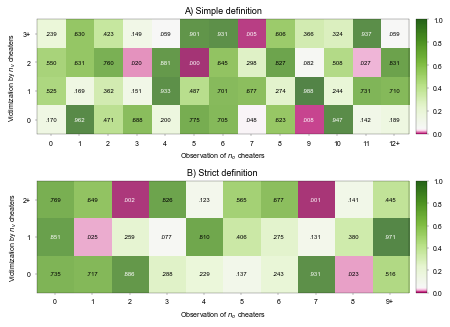

<Figure size 504x504 with 0 Axes>

In [83]:
def plot_heatmap(ax, piv, xticks, yticks, title, cbar=True):
    colnorm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)
    img1 = ax.imshow(piv, alpha=0.8, norm=colnorm)
    ax.set_xticks(np.arange(piv.shape[1]))
    ax.set_xticklabels(xticks)
    ax.set_yticks(np.arange(piv.shape[0]))
    ax.set_yticklabels(yticks)
    ax.title.set_text(title)
    ax.set_xlabel(r'Observation of $n_o$ cheaters')
    ax.set_ylabel(r'Victimization by $n_v$ cheaters')

    textcolors = ["k", "w"]
    for x in range(piv.shape[1]):
        for y in range(piv.shape[0]):
            if np.isnan(piv.iloc[y, x]) == False:
                text = ax.text(x, y, ('%.3f' % piv.iloc[y, x]).lstrip('0'), ha="center", va="center", fontsize=6,
                               color=textcolors[1 if piv.iloc[y, x] <= 0.01 or piv.iloc[y, x] >= 0.85 else 0])
    if cbar:
        cbar = colorbar(img1)
        cbar.solids.set_edgecolor("face")


### Plot a heatmap of P-values (z-scores).
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5.4))

piv1 = get_simple()
print(piv1)
xticks1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, '12+']
yticks1 = [0, 1, 2, '3+']
plot_heatmap(ax1, piv1, xticks1, yticks1, 'A) Simple definition')

piv2 = get_strict()
print(piv2)
xticks2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, '9+']
yticks2 = [0, 1, '2+']
plot_heatmap(ax2, piv2, xticks2, yticks2, 'B) Strict definition')

plt.show()
plt.tight_layout()
fig.savefig('figs/z-scores/zscore_p_val.png')

## 2) Plot a heatmap of P-values based on Poisson statistics 

total_obs     0      1      2      3      4      5      6      7      8   \
total_exp                                                                  
0          0.332  0.804  0.493  0.635  0.300  0.743  0.680  0.124  0.616   
1          0.531  0.257  0.404  0.222  0.907  0.515  0.693  0.695  0.318   
2          0.570  0.706  0.784  0.063  0.887  0.006  0.692  0.373  0.846   
3          0.347  1.000  0.564  0.253  0.112  1.000  1.000  0.036  0.689   

total_obs     9      10     11     12  
total_exp                              
0          0.053  0.945  0.218  0.308  
1          0.986  0.310  0.777  0.682  
2          0.129  0.566  0.056  0.831  
3          0.454  0.409  1.000  0.196  


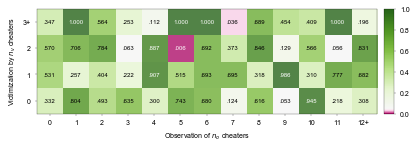

total_obs      0      1      2      3      4      5      6      7      8  \
sev_exp                                                                    
0          0.605  0.643  0.778  0.361  0.331  0.213  0.322  0.924  0.123   
1          0.811  0.095  0.349  0.144  0.805  0.448  0.347  0.204  0.457   
2          0.789  0.723  0.016  0.876  0.182  0.615  0.736  0.016  0.209   

total_obs      9  
sev_exp           
0          0.538  
1          0.936  
2          0.507  


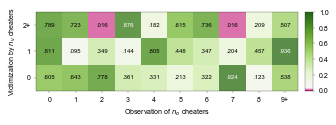

In [84]:
def get_simple_poiss():
    merged_df = pd.read_csv('data/RO_RE.csv')
    test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)

    col_list = list(test_dat.columns[2:])
    res = test_dat.groupby([test_dat.total_exp, pd.cut(test_dat.total_obs, 
                                                       [-np.inf, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, np.inf], 
                                                       labels = [0, 1, 2, 3, 4, 5, 6, 
                                                                 7, 8, 9, 10, 11, 12])])[col_list].sum().reset_index()

    test_dat = res.groupby([res.total_obs, pd.cut(res.total_exp,[-np.inf, 0, 1, 2, np.inf], 
                                                  labels = [0, 1, 2, 3])])[col_list].sum().reset_index()

    test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
    test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
    test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
    test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

    test_dat = test_dat.round({"rand_mean":2, "cdf":3, "pmf":3, "prob":3})

    piv = pd.pivot_table(test_dat, values="prob",index=["total_exp"], columns=["total_obs"])
    return piv

def get_strict_poiss():
    merged_df = pd.read_csv('data/SO_SE.csv')
    test_dat = merged_df.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)

    col_list = list(test_dat.columns[2:])
    res = test_dat.groupby([test_dat.sev_exp, pd.cut(test_dat.total_obs, 
                                                       [-np.inf, 0, 1, 2, 3, 4, 5, 6, 7, 8, np.inf], 
                                                       labels = [0, 1, 2, 3, 4, 
                                                                 5, 6, 7, 8, 9])])[col_list].sum().reset_index()

    test_dat = res.groupby([res.total_obs, pd.cut(res.sev_exp,[-np.inf, 0, 1, np.inf], 
                                                  labels = [0, 1, 2])])[col_list].sum().reset_index()

    test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
    test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['E'], test_dat['rand_mean'])
    test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['E'], test_dat['rand_mean'])
    test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

    test_dat = test_dat.round({"rand_mean":2, "cdf":3, "pmf":3, "prob":3})
    
    piv = pd.pivot_table(test_dat, values="prob",index=["sev_exp"], columns=["total_obs"])
    return piv

    
    
### Plot a heatmap of P-values (Poisson).
fig, ax1 = plt.subplots(1, 1, figsize=(5.8, 2))
piv1 = get_simple_poiss()
print(piv1)
xticks1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, '12+']
yticks1 = [0, 1, 2, '3+']
plot_heatmap(ax1, piv1, xticks1, yticks1, '')
plt.tight_layout()
plt.show()
fig.savefig('figs/paper/poiss_simple_detail.pdf', format='pdf')


fig, ax2 = plt.subplots(1, 1, figsize=(4.68, 1.6))
piv2 = get_strict_poiss()
print(piv2)
xticks2 = [0, 1, 2, 3, 4, 5, 6, 7, 8, '9+']
yticks2 = [0, 1, '2+']
plot_heatmap(ax2, piv2, xticks2, yticks2, '')

plt.tight_layout()
plt.show()
fig.savefig('figs/paper/poiss_strict_detail.pdf', format='pdf')


### 3) Calculate the P-values of each motif - (1, 0), (0, 1), and (1, 1).

O      0      1
V              
0    NaN  0.093
1  0.312  0.018
O      0      1
V              
0    NaN  0.232
1  0.926  0.000


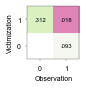

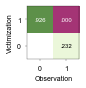

In [91]:
simple_df = pd.DataFrame({"O": [0, 0, 1, 1], 
                          "V": [0, 1, 0, 1], 
                          "p_val": [np.NaN, 0.312, 0.093, 0.018]})

strict_df = pd.DataFrame({"O": [0, 0, 1, 1], 
                          "V": [0, 1, 0, 1], 
                          "p_val": [np.NaN, 0.926, 0.232, 0.000]})

simple_piv = pd.pivot_table(simple_df, values="p_val",index=["V"], columns=["O"])
print(simple_piv)

strict_piv = pd.pivot_table(strict_df, values="p_val",index=["V"], columns=["O"])
print(strict_piv)

def plot_heatmap_small(ax, piv, title):
    colnorm = DivergingNorm(vmin=0, vcenter=0.05, vmax=1)
    img1 = ax.imshow(piv, alpha=0.8, norm=colnorm)
    ax.set_xticks(np.arange(piv.shape[0]))
    ax.set_yticks(np.arange(piv.shape[1]))
    ax.title.set_text(title)
    ax.set_xlabel('Observation')
    ax.set_ylabel('Victimization')

    textcolors = ["k", "w"]
    for x in range(piv.shape[0]):
        for y in range(piv.shape[1]):
            if np.isnan(piv.iloc[y, x]) == False:
                text = ax.text(x, y, ('%.3f' % piv.iloc[y, x]).lstrip('0'), ha="center", va="center",
                               color=textcolors[1 if piv.iloc[y, x] <= 0.01 or piv.iloc[y, x] >= 0.85 else 0], fontsize=6)

    #cbar = colorbar(img1)
    #cbar.solids.set_edgecolor("face")


### Plot a heatmap of P-values (z-scores).
fig, ax1 = plt.subplots(1, 1, figsize=(1.2, 1.3))
plot_heatmap_small(ax1, simple_piv, '')
plt.subplots_adjust(bottom=0.32, left=0.25)
plt.show()
#plt.tight_layout()
fig.savefig('figs/paper/poiss_simple.pdf', format='pdf')

fig, ax2 = plt.subplots(1, 1, figsize=(1.2, 1.3))
plot_heatmap_small(ax2, strict_piv, '')
plt.subplots_adjust(bottom=0.32, left=0.25)
plt.show()
#plt.tight_layout()
fig.savefig('figs/paper/poiss_strict.pdf', format='pdf')


### 3-1) Calculate the test statistics - strict def. of experience and observation.

Count the total number of the motif (0, 1).

In [58]:
merged_df = pd.read_csv('data/SO_SE.csv')

# Drop the rows with zero experience or zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) & (merged_df.sev_exp == 0)].index)
test_dat = test_dat.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)
# print(test_dat.head())

test_dat = test_dat[test_dat.sev_exp == 0]
temp_dat = test_dat.loc[:,'E':].multiply(test_dat['total_obs'], axis="index")

temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
# print(temp_dat.tail(1))
# print(temp_dat.iloc[-1, 0])
# print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 3)))
print("rand_std: " + str(round(rand_std, 3)))
print("z-score: " + str(round(z_score, 3)))
print("p_val (z-score): " + str(round(p_val, 3)))
print("cdf: " + str(round(cdf, 3)))
print("pmf: " + str(round(pmf, 3)))
print("prob (Poisson p-value): " + str(round(prob, 3)))
print("cum_prop: " + str(round(cum_prop, 3)))

# temp_dat.to_csv('sum_tab.csv', index=False)

rand_mean: 1616.71
rand_std: 35.957
z-score: 0.731
p_val (z-score): 0.232
cdf: 0.748
pmf: 0.008
prob (Poisson p-value): 0.26
cum_prop: 0.23


Count the total number of the motif (1, 0).

In [59]:
merged_df = pd.read_csv('data/SO_SE.csv')

# Drop the rows with zero experience or zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) & (merged_df.sev_exp == 0)].index)
test_dat = test_dat.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)
# print(test_dat.head())

# Calculate the test statistics of the motif (1, 0).
test_dat = test_dat[test_dat.total_obs == 0]
temp_dat = test_dat.loc[:,'E':].multiply(test_dat['sev_exp'], axis="index")
# print(temp_dat)

temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
# print(temp_dat.tail(1))
# print(temp_dat.iloc[-1, 0])
# print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 3)))
print("rand_std: " + str(round(rand_std, 3)))
print("z-score: " + str(round(z_score, 3)))
print("p_val (z-score): " + str(round(p_val, 3)))
print("cdf: " + str(round(cdf, 3)))
print("pmf: " + str(round(pmf, 3)))
print("prob: " + str(round(prob, 3)))
print("cum_prop: " + str(round(cum_prop, 3)))

# temp_dat.to_csv('sum_tab.csv', index=False)

rand_mean: 78.71
rand_std: 6.724
z-score: -1.444
p_val (z-score): 0.926
cdf: 0.149
pmf: 0.026
prob: 0.877
cum_prop: 0.94


Count the total number of the motif (1, 1).

In [60]:
merged_df = pd.read_csv('data/SO_SE.csv')

# Drop the rows with zero experience and zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) | (merged_df.sev_exp == 0)].index)
test_dat = test_dat.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)
test_dat['num_pairs'] = np.where(test_dat['total_obs'] <= test_dat['sev_exp'], 
                                 test_dat['total_obs'], test_dat['sev_exp'])

temp_dat = test_dat.loc[:,'E':'R100'].multiply(test_dat['num_pairs'], axis="index")

# Calculate the total number of the motif (1, 1) for each network.
temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
# print(temp_dat.tail(1))
# print(temp_dat.iloc[-1, 0])
# print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 3)))
print("rand_std: " + str(round(rand_std, 3)))
print("z-score: " + str(round(z_score, 3)))
print("p_val (z-score): " + str(p_val))
print("cdf: " + str(round(cdf, 3)))
print("pmf: " + str(round(pmf, 3)))
print("prob: " + str(prob))
print("cum_prop: " + str(cum_prop))

rand_mean: 287.56
rand_std: 10.884
z-score: 4.083
p_val (z-score): 2.2239413893232474e-05
cdf: 0.995
pmf: 0.001
prob: 0.005563987272046569
cum_prop: 0.0


### 3-2) Calculate the test statistics - simple def. of experience and observation.

In [61]:
merged_df = pd.read_csv('data/RO_RE.csv')

# Drop the rows with zero experience or zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) & (merged_df.total_exp == 0)].index)
test_dat = test_dat.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
# print(test_dat.head())

# Calculate the test statistics of the motif (0, 1).
test_dat = test_dat[test_dat.total_exp == 0]
# print(test_dat.head())
temp_dat = test_dat.loc[:,'E':].multiply(test_dat['total_obs'], axis="index")
# print(temp_dat)

# Calculate the total number of the motif (0, 1) for each network.
temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
# print(temp_dat.tail(1))
# print(temp_dat.iloc[-1, 0])
# print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 3)))
print("rand_std: " + str(round(rand_std, 3)))
print("z-score: " + str(round(z_score, 3)))
print("p_val (z-score): " + str(p_val))
print("cdf: " + str(round(cdf, 3)))
print("pmf: " + str(round(pmf, 3)))
print("prob: " + str(prob))
print("cum_prop: " + str(cum_prop))
# temp_dat.to_csv('sum_tab.csv', index=False)

rand_mean: 3273.69
rand_std: 78.281
z-score: 1.32
p_val (z-score): 0.09346136822889806
cdf: 0.965
pmf: 0.001
prob: 0.036688103878657397
cum_prop: 0.1


In [62]:
merged_df = pd.read_csv('data/RO_RE.csv')

# Drop the rows with zero experience or zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) & (merged_df.total_exp == 0)].index)
test_dat = test_dat.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
# print(test_dat.head())

# Calculate the test statistics of the motif (1, 0).
test_dat = test_dat[test_dat.total_obs == 0]
# print(test_dat.head())
temp_dat = test_dat.loc[:,'E':].multiply(test_dat['total_exp'], axis="index")

# Calculate the total number of the motif (1, 0) for each network.
temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
# print(temp_dat.tail(1))
# print(temp_dat.iloc[-1, 0])
# print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 3)))
print("rand_std: " + str(round(rand_std, 3)))
print("z-score: " + str(round(z_score, 3)))
print("p_val (z-score): " + str(p_val))
print("cdf: " + str(round(cdf, 3)))
print("pmf: " + str(round(pmf, 3)))
print("prob: " + str(prob))
print("cum_prop: " + str(cum_prop))

rand_mean: 186.27
rand_std: 9.676
z-score: 0.489
p_val (z-score): 0.312485884542394
cdf: 0.653
pmf: 0.027
prob: 0.3741259562187964
cum_prop: 0.35


In [63]:
# Count the number of the motif (1, 1).
merged_df = pd.read_csv('data/RO_RE.csv')

# Drop the rows with zero experience and zero observation.
test_dat = merged_df.drop(merged_df[(merged_df.total_obs == 0) | (merged_df.total_exp == 0)].index)
test_dat = test_dat.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
test_dat['num_pairs'] = np.where(test_dat['total_obs'] <= test_dat['total_exp'], 
                                 test_dat['total_obs'], test_dat['total_exp'])

temp_dat = test_dat.loc[:,'E':'R100'].multiply(test_dat['num_pairs'], axis="index")

# Calculate the total number of the motif (1, 1) for each network.
temp_dat.loc['total'] = temp_dat.iloc[:, :].sum()
# print(temp_dat.tail(1))
# print(temp_dat.iloc[-1, 0])
# print(temp_dat.iloc[-1, 1:].values)
cnt = (temp_dat.iloc[-1, 1:].values >= temp_dat.iloc[-1, 0]).sum().astype(int)
cum_prop = round(cnt/100, 2)

# Calculate p-values.
rand_mean = float(temp_dat.iloc[-1:, 1:].mean(axis=1))
rand_std = float(temp_dat.iloc[-1:, 1:].std(axis=1))
z_score = norm.ppf(norm.cdf(x=temp_dat.iloc[-1, 0],loc=rand_mean, scale=rand_std))
p_val = 1 - norm.cdf(z_score)
cdf = float(scipy.stats.poisson.cdf(temp_dat.iloc[-1, 0], rand_mean))
pmf = float(scipy.stats.poisson.pmf(temp_dat.iloc[-1, 0], rand_mean))
prob = 1 - cdf + pmf

print("rand_mean: " + str(round(rand_mean, 3)))
print("rand_std: " + str(round(rand_std, 3)))
print("z-score: " + str(round(z_score, 3)))
print("p_val (z-score): " + str(p_val))
print("cdf: " + str(round(cdf, 3)))
print("pmf: " + str(round(pmf, 3)))
print("prob: " + str(prob))
print("cum_prop: " + str(cum_prop))

rand_mean: 703.55
rand_std: 17.4
z-score: 2.095
p_val (z-score): 0.018095507186522863
cdf: 0.917
pmf: 0.006
prob: 0.08846334919894476
cum_prop: 0.0


 ### 6) Plot the number of counts in cells.

In [68]:
merged_df = pd.read_csv('data/RO_RE.csv')
merged_df = merged_df.drop(merged_df[merged_df.total_obs > 20].index)
test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)
freq_piv_1 = pd.pivot_table(test_dat, values="E",index=["total_exp"], columns=["total_obs"])
print(freq_piv_1)

merged_df = pd.read_csv('data/SO_SE.csv')
merged_df = merged_df.drop(merged_df[merged_df.total_obs > 20].index)
merged_df = merged_df.drop(merged_df[merged_df.sev_exp > 6].index)
test_dat = merged_df.sort_values(['sev_exp', 'total_obs']).reset_index(drop=True)
freq_piv_2 = pd.pivot_table(test_dat, values="E",index=["sev_exp"], columns=["total_obs"])
print(freq_piv_2)

total_obs     0      1      2      3     4     5     6     7     8     9   \
total_exp                                                                   
0          183.0  381.0  214.0  130.0  97.0  52.0  36.0  37.0  19.0  22.0   
1          101.0   60.0   53.0   49.0  27.0  28.0  23.0  21.0  20.0   9.0   
2           22.0    2.0    4.0   14.0   5.0  13.0   6.0   8.0   5.0   9.0   
3            9.0    0.0    1.0    2.0   2.0   0.0   0.0   2.0   2.0   2.0   
4            1.0    NaN    0.0    0.0   1.0   0.0   0.0   2.0   0.0   0.0   
5            3.0    NaN    NaN    NaN   NaN   0.0   0.0   1.0   0.0   1.0   
6            0.0    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   
7            0.0    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   
8            NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   

total_obs  ...   11   12   13   14   15   16   17   18   19   20  
total_exp  ...                                                    
0          ...  9.

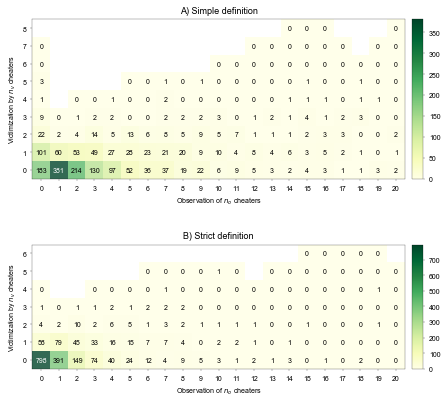

<Figure size 504x504 with 0 Axes>

In [67]:
### Plot a heatmap of frequencies.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))

img1 = ax1.imshow(freq_piv_1, cmap='YlGn', alpha=0.8)
ax1.set_xticks(np.arange(freq_piv_1.shape[1]))
ax1.set_yticks(np.arange(freq_piv_1.shape[0]))
ax1.set_xlabel(r'Observation of $n_o$ cheaters')
ax1.set_ylabel(r'Victimization by $n_v$ cheaters')
ax1.title.set_text('A) Simple definition')

textcolors = ["k", "w"]
for y in range(freq_piv_1.shape[0]):
    for x in range(freq_piv_1.shape[1]):
        if np.isnan(freq_piv_1[x][y]) == False:
            text = ax1.text(x, y, int(freq_piv_1[x][y]), ha="center", va="center",
                            color=textcolors[1 if freq_piv_1[x][y] >= 350 else 0])

cbar = colorbar(img1)
cbar.solids.set_edgecolor("face")

img2 = ax2.imshow(freq_piv_2, cmap='YlGn', alpha=0.8)
ax2.set_xticks(np.arange(freq_piv_2.shape[1]))
ax2.set_yticks(np.arange(freq_piv_2.shape[0]))
ax2.set_xlabel(r'Observation of $n_o$ cheaters')
ax2.set_ylabel(r'Victimization by $n_v$ cheaters')
ax2.title.set_text('B) Strict definition')

textcolors = ["k", "w"]

for y in range(freq_piv_2.shape[0]):
    for x in range(freq_piv_2.shape[1]):
        if np.isnan(freq_piv_2[x][y]) == False:
            text = ax2.text(x, y, int(freq_piv_2[x][y]), ha="center", va="center",
                            color=textcolors[1 if freq_piv_2[x][y] >= 400 else 0])

cbar = colorbar(img2)
cbar.solids.set_edgecolor("face")

plt.show()
plt.tight_layout()
fig.savefig('figs/paper/fig_s5.pdf', format='pdf')